title: Overdraft Expansion Opportunity Sizing 
author: Hugh Huyton
date: 2023-05-15 
region: EU  
link: https://docs.google.com/presentation/d/1SgAkcwWHP9zbQEdcTcYvkh7Ws6JcjFymZ8vEzLACIP0/edit
tags: Overdraft, bank products, credit risk, lisbon, transactions
summary: In this research we look to understand the potential of an Overdraft product for the Spanish market, utilizing insights from the rollout of Overdraft in Germany. Based on the following user groups: I am in an emergency and I need some money; I am expecting some money but it’s not here yet and I need money for a few days for a purchase/payment; I don’t want to use my savings/ investments/ cash but need money to cover some costs - we would like to validate the assumption that based on the opportunity sizes of each use case, there is room for either evolving Overdraft as it is or creating a new solution to serve these users. For each of the groups identified, we would like to validate their identity based on the following characteristics: Demographics, N26 tiers, Rating classs,Tx data, If MAU or PAU and OD usage (for German users).


<div class="alert alert-block alert-info">
<b>Task description:</b> As a PM, I would like to map and understand the different use cases that Overdraft could serve in the Spanish market in order to validate the user problem and gain confidence in its opportunity size in the next market.
</div>

<div class="alert alert-block alert-info">
<b>Background context:</b> As part of this discovery <a href="https://number26-jira.atlassian.net/browse/FG-11580">FG-11580: [Overdraft] Expanding to a new market: Spain</a>
 , we’re currently trying to measure the opportunity for such a product in the Spanish market based on the different use cases that Overdraft serves today in Germany with its “safety net” value proposition:

1. I am in an emergency and I need some money
2. I am expecting some money but it’s not here yet and I need money for a few days for a purchase/payment
3. I don’t want to use my savings/ investments/ cash but need money to cover some costs

We understand that Overdraft, as _a credit limit linked to the user's N26 main account which allows them to continue spending up to a certain maximum amount after their account balance is 0_,  should __primarily__ serve the needs of customers in situation number 1. 

However, after a few years in the German market, we have learned that the original composition of the Overdraft product has been also used by customers in cases 2 & 3, often generating undesired repayment habits for some user groups, which are not aligned with its core value proposition nor with the company’s profitability goal, since it has resulted in high probability of default rates from these user groups. 

Nevertheless, we would like to validate the assumption that based on the opportunity sizes of each use case, there is room for either evolving Overdraft as it is or creating a new solution to serve these users.
</div>

<div class="alert alert-block alert-success">
<b>Expected goal:</b>

We would like to understand (as in create an identity) to the potential use cases in Germany and in Spain by grouping them as follows:

__Group 1__: Balance account close to 0 or negative (unarranged OD) + Rejected transactions due to lack of funds

__Group 2__: Balance account close to 0 or negative (unarranged OD) + Rejected transactions + history of regular income/salary account or Rejected transactions due to insufficient funds just before regular income is deposited

__Group 3__: Balance account close to 0 or negative (unarranged OD) + Rejected transactions + have funds somewhere else (spaces, investment etc) OR topped up account from available sources of funds to cover an expense (including “Pay from Spaces” feature)

__Group 4__: Balance account is not close to 0 + Rejected transactions OR expected future (recurring) payment > the account balance.

* For Germany users, we need to know if they have arranged OD in use or if they have use it in the past 6 months
* For both (Spain and Germany), mark if user would be eligible to OD based on current criteria
* For each group, we should be able to build an identity, based on:
    * Demographics
    * N26 tiers
    * Rating class
    * Tx data <a href="https://research.tech26.de/reports/20220711_what_do_customers_use_overdraft_for.html">(What do customers use Overdraft for?)</a>
    * If MAU or PAU

* On German users, it’d be interesting to check about their OD usage:
    * Duration
    * Amount (outstanding balance)
    * Max. & Avg.
    * Frequency
    * Repayment x Dunning behavior

Source of exercise: <a href="https://www.figma.com/file/3zfE9rY0k3PdCzlhXNcayH/Overdraft-Expansion?node-id=403-569&t=vdmE9U2W7SjWDnVS-4">Figma</a>
</div>

In [109]:
import gspread
import pandas as pd
import os
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from analyticsdb_local import df_to_db, df_from_sql

# If modifying these SCOPES, delete the file token.json.
SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive",
]

# The file token.json stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
creds = None
if os.path.exists("token.json"):
    creds = Credentials.from_authorized_user_file("token.json", SCOPES)

# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file("client_secret.json", SCOPES)
        creds = flow.run_local_server(port=0)

    # Save the credentials for the next run
    with open("token.json", "w") as token:
        token.write(creds.to_json())

# Connect to the Google Sheets API using the created credentials
client = gspread.authorize(creds)

In [97]:
base_query = """
select datediff('months', u.user_created, mmb.date) as month_cohort,
       sum(balance_eur)                               as balance
from dbt.zrh_users u
inner join dwh_cohort_months as m on m.end_time >= u.user_created
inner join dbt.mmb_monthly_balance_aud mmb on mmb.user_created = u.user_created and to_char(mmb.date, 'YYYY-MM') = to_char(m.end_time, 'YYYY-MM')
where  month_cohort <= 12
  and u.user_created < date_trunc('month', current_date)
  and u.user_created >= current_date - interval '24 months'
group by 1
order by 1
"""
cohorts = df_from_sql(database="redshiftadmin", query=base_query)

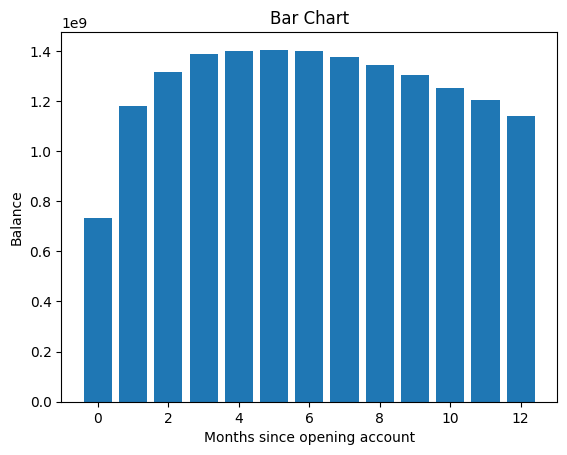

In [107]:
import matplotlib.pyplot as plt

# Plotting the bar chart
plt.bar(cohorts["month_cohort"], cohorts["balance"])

# Adding labels and title
plt.xlabel("Months since opening account")
plt.ylabel("Balance")
plt.title("Bar Chart")

# Displaying the chart
plt.show()

<div class="alert alert-block alert-danger">
<b>Group 1:</b> Balance account close to 0 or negative (unarranged OD) + Rejected transactions due to lack of funds + No funds elsewhere + No regular income
</div> 

In [7]:
custom_sql = f"""
select user_id, g1.user_created
 from dev_dbt.g1_low_balance_rejected_txn_no_funds_income_temp g1
          left join dev_dbt.g2_low_balance_rejected_txn_history_income g2_1 using (user_id)
          left join dev_dbt.g3_low_balance_rejected_txn_funds_elsewhere g3_1 using (user_id)
          left join dev_dbt.g3_topped_up_to_cover_expense g3_2 using (user_id)
          left join dev_dbt.g4_expected_payment_greater_account_balance g4_1 using (user_id)
          left join dev_dbt.g4_high_balance_rejected_txns g4_2 using (user_id)
 where 
   g1.country = 'DEU'
   and g1.tnc_country_group = 'DEU'
   and g2_1.user_id is null
   and g3_1.user_id is null
   and g3_2.user_id is null
   and g4_1.user_id is null
   and g4_2.user_id is null
"""
DEU = df_from_sql(database="redshiftadmin", query=custom_sql)
DEU.head()

In [8]:
custom_sql = f"""
select user_id, g1.user_created
 from dev_dbt.g1_low_balance_rejected_txn_no_funds_income_temp g1
          left join dev_dbt.g2_low_balance_rejected_txn_history_income g2_1 using (user_id)
          left join dev_dbt.g3_low_balance_rejected_txn_funds_elsewhere g3_1 using (user_id)
          left join dev_dbt.g3_topped_up_to_cover_expense g3_2 using (user_id)
          left join dev_dbt.g4_expected_payment_greater_account_balance g4_1 using (user_id)
          left join dev_dbt.g4_high_balance_rejected_txns g4_2 using (user_id)
 where 
   g1.country = 'ESP'
   and g1.tnc_country_group = 'ESP'
   and g2_1.user_id is null
   and g3_1.user_id is null
   and g3_2.user_id is null
   and g4_1.user_id is null
   and g4_2.user_id is null
   
"""
ESP = df_from_sql(database="redshiftadmin", query=custom_sql)
ESP.head()

In [9]:
custom_sql = f"""
select age_group,
count(distinct user_id) users,
1.00 * users / sum(users) over ()
--avg(1.00 * datediff('years', birth_date, current_date))
from dbt.zrh_users u
--inner join cmd_users cu on cu.id = u.user_id
where u.user_id IN {tuple(ESP['user_id'])}
group by 1
"""
df = df_from_sql(database="redshiftadmin", query=custom_sql)
df.head()

In [10]:
custom_sql = f"""
select 
count(distinct case when overdraft_eligible_score then user_id end) od_eligible,
count(distinct case when tbil_eligible_score then user_id end) tb_eligible
from dbt.stg_lisbon_eligible_users
where user_id IN {tuple(ESP['user_id'])}
"""
df = df_from_sql(database="redshiftadmin", query=custom_sql)
df.head()

In [11]:
custom_sql = f"""
select product_pau_flg,
count(distinct user_id) users,
1.00 * users / sum(users) over ()
from dbt.zrh_users u
left join dbt.zrh_primary_accounts pau on pau.user_created = u.user_created and to_char(txn_month, 'yyyy-mm') = '2023-04'
where u.user_id IN {tuple(ESP['user_id'])}
group by 1

"""
df = df_from_sql(database="redshiftadmin", query=custom_sql)
df.head()

In [12]:
custom_sql = f"""
select count(distinct u.user_created) all_users
from dbt.zrh_users u
         inner join dbt.bp_overdraft_users ou
                    on ou.user_created = u.user_created
                        and outstanding_balance_eur is not null
                        and od_enabled_flag = false
where u.user_id IN {tuple(DEU['user_id'])}
"""
df = df_from_sql(database="redshiftadmin", query=custom_sql)
df.head()

In [13]:
custom_sql = f"""
select count(distinct u.user_created) users,
       count(distinct ou.user_created) as od
from dbt.zrh_users u
   inner join cmd_address
                   on u.user_id = cmd_address.user_id
                       and cmd_address.type = 'LEGAL'
                       and cmd_address.country = 'ESP' -- DE based users
    left join dbt.bp_overdraft_users ou
                    on ou.user_created = u.user_created
                        and outstanding_balance_eur is not null
                        and od_enabled_flag = false
where u.closed_at is null -- account still open
 and tnc_country_group = 'ESP'
 and kyc_first_completed <= current_date - interval '6 months' --users with at least 6 months of activity
"""
df = df_from_sql(database="redshiftadmin", query=custom_sql)
df.head()

In [14]:
custom_sql = f"""
select sum(used_overdraft_6m),
       count(distinct user_id)
from 
(select bpu.user_id,
max(case when od_active_user = true then 1 else 0 end) as used_overdraft_6m
from dbt.bank_products_users bpu
where od_active_user
and user_id IN {tuple(DEU['user_id'])}
and end_time >= current_date - interval '6 months'
group by 1)
"""
df = df_from_sql(database="redshiftadmin", query=custom_sql)
df.head()

In [15]:
custom_sql = f"""
select avg(1.00 * internal_rating_class)
from (select user_id,
             end_time,
             internal_rating_class,
             row_number() over (partition by user_id order by end_time desc) as rn
      from dbt.zrh_users
               inner join dbt_pii.user_credit_scores using (user_id)
        where zrh_users.user_id IN {tuple(DEU['user_id'])})
where rn = 1
"""
df = df_from_sql(database="redshiftadmin", query=custom_sql)
df.head()

In [17]:
custom_sql = f"""
select avg(1.00 * n_txns),
       1.0 * sum(volume) / sum(n_txns) as amount_per_txn
from
(select u.user_id,
       to_char(txn_ts, 'YYYY-MM'),
       count(distinct txn_id) as n_txns,
       sum(1.00 * abs_amount_cents) as volume
from dbt.zrh_users u
inner join dbt.zrh_transactions txns on txns.user_created = u.user_created and txn_ts >= current_date - interval '6 months'
where u.user_id IN {tuple(DEU['user_id'])}
and txns.type not in ('AA', 'DR', 'PF', 'PRESENTMENT_REFUND', 'WU')
        and n26_init_txn_flg = false
group by 1,2
order by 1,2)
"""
df = df_from_sql(database="redshiftadmin", query=custom_sql)
df.head()

In [18]:
custom_sql = f"""
select avg(1.00 * n_txns),
       1.0 * sum(volume) / sum(n_txns) as amount_per_txn
from
(select u.user_id,
       to_char(txn_ts, 'YYYY-MM'),
       count(distinct txn_id) as n_txns,
       sum(1.00 * abs_amount_cents) as volume
from dbt.zrh_users u
inner join cmd_address
                   on u.user_id = cmd_address.user_id
                       and cmd_address.type = 'LEGAL'
                       and cmd_address.country = 'ESP' -- DE based users
inner join dbt.zrh_transactions txns on txns.user_created = u.user_created and txn_ts >= current_date - interval '6 months' and txns.type not in ('AA', 'DR', 'PF', 'PRESENTMENT_REFUND', 'WU')
and n26_init_txn_flg = false
where u.closed_at is null -- account still open
 and tnc_country_group = 'ESP'
 and kyc_first_completed <= current_date - interval '6 months' --users with at least 6 months of activity
group by 1,2
order by 1,2)
"""
df = df_from_sql(database="redshiftadmin", query=custom_sql)
df.head()

In [20]:
custom_sql = f"""
with totals as (
select
    t.user_created,
    case when t.reference_to_original_operation = 'ConsumerCredit' then 'Loan Repayment'
        when fee_label like 'memberships_%%' then 'memberships' 
        when t.type = 'WEE' and fee_label is not null then fee_label
        when t.type = 'WEE' then 'Uncategorized fee'
        when payment_scheme = 'SPACES' and account_role = 'SECONDARY' then 'SPACES'
        when t.type = 'PT' then 'Card PT - ' || mcc_category
        when t.type in ('DT', 'CT', 'DD') and a.category is not null then a.category
        when t.type = 'DT' then 'Uncategorized Direct Transfer'
        when t.type = 'CT' then 'Uncategorized Credit Transfer'
        when t.type = 'DD' then 'Uncategorized Direct Debit'
        when t.type = 'FT' then 'Moneybeam'
        when t.type = 'WU' then 'Reward Transfer'
        when t.type = 'DR' then 'Direct Debit Reversal'
        when t.type = 'TUB' then 'Wise Transfer (Foreign Currency)'
        else t.type end as type,
    count(case when t.amount_cents > 0 then 1 end) as n_incoming_txns, 
    count(case when t.amount_cents < 0 then 1 end) as n_outgoing_txns,
    sum(case when t.amount_cents > 0 then t.abs_amount_cents end) as incoming_txn_volume, 
    sum(case when t.amount_cents < 0 then t.abs_amount_cents end) as outgoing_txn_volume,
    case when sum(n_incoming_txns::numeric) over(partition by t.user_created) = 0 then 0 else n_incoming_txns::numeric/sum(n_incoming_txns::numeric) over(partition by t.user_created) end as perc_incoming_txns_per_user, 
    case when sum(incoming_txn_volume::numeric) over(partition by t.user_created) = 0 then 0 else incoming_txn_volume::numeric/sum(incoming_txn_volume::numeric) over(partition by t.user_created) end as perc_incoming_txn_volume_per_user, 
    case when sum(n_outgoing_txns::numeric) over(partition by t.user_created) =0 then 0 else n_outgoing_txns::numeric/sum(n_outgoing_txns::numeric) over(partition by t.user_created) end as perc_outgoing_txns_per_user, 
    case when sum(outgoing_txn_volume::numeric) over(partition by t.user_created) = 0 then 0 else outgoing_txn_volume::numeric/sum(outgoing_txn_volume::numeric) over(partition by t.user_created) end as perc_outgoing_txn_volume_per_user
from dbt.zrh_transactions t
left join dbt.zrh_card_transactions ct on t.txn_id = ct.id and created >= current_date - interval '6 month'
left join dbt.ucm_fees on txn_id = fee_id
left join amh_categories a on a.id = t.txn_id and created_ts >= current_date - interval '6 month'
where t.user_created in {tuple(ESP['user_id'])}
and txn_ts >= current_date - interval '6 month' 
and t.type != 'AA' 
and n26_init_txn_flg = false
group by 1,2
)
select 
    type,
    avg(perc_incoming_txns_per_user) as perc_incoming_txns_per_user,
    avg(perc_incoming_txn_volume_per_user) as perc_incoming_txn_volume_per_user,
    avg(perc_outgoing_txns_per_user) as perc_outgoing_txns_per_user,
    avg(perc_outgoing_txn_volume_per_user) as perc_outgoing_txn_volume_per_user
from totals
group by 1

"""
df = df_from_sql(database="redshiftadmin", query=custom_sql)
df.head()

In [22]:
custom_sql = f"""
select
    count(distinct ou.user_created)
from dbt.bp_overdraft_users ou
where od_enabled_flag
    and user_created IN {tuple(DEU['user_id'])}
    and outstanding_balance_eur is not null    
"""
df = df_from_sql(database="redshiftadmin", query=custom_sql)
df.head()

In [24]:
custom_sql = f"""
with od_users as (
select
    end_time,
    ou.user_created,
    outstanding_balance_eur,
    max_amount_cents::numeric/100 as max_amount_eur,
    outstanding_balance_eur::numeric/max_amount_eur as perc_usage
from dbt.bp_overdraft_users ou
where od_enabled_flag
    and ou.user_created IN {tuple(DEU['user_id'])}
    and timeframe = 'day'
),
--Then we aggregate it on a monthly basis and find how many days in a month users use OD
monthly_usage as (
select
    date_trunc('month', end_time) as month,
    user_created,
    count(case when outstanding_balance_eur is not null then 1 end) as n_days,
    min(max_amount_eur) as min_limit,
    avg(perc_usage) as avg_perc_usage
from od_users
group by 1, 2
),
-- Then we group the avg number of days per month into our 4 buckets
days_buckets as (
select 
    user_created,
    case when avg(n_days) = 0 then ' not using od'
    when avg(n_days) <= 10 then '<=10'
    when avg(n_days) <= 27 then '>=11 and <= 27'
    else '>=28' end as days_bucket,
    case when avg(n_days) = 0 then 0 else avg(avg_perc_usage) end as avg_perc_usage --excluding outliers that use od a couple of days but avg is 0
from monthly_usage
group by 1
)
select
case when avg_perc_usage >1 then 'in arrears'
    when days_bucket = ' not using od' then '0%%'
    when avg_perc_usage < 0.2 then '<=20%%'
    when avg_perc_usage between 0.2 and 0.4 then '20%% to 40%%'
    when avg_perc_usage between 0.4 and 0.6 then '40%% to 60%%'
    when avg_perc_usage between 0.6 and 0.8 then '60%% to 80%%'
    when avg_perc_usage between 0.8 and 0.9 then '80%% to 90%%'
    when avg_perc_usage > 0.9 then '> 90%%'
    end as usage_buckets,
days_bucket,
count(distinct u.user_created) as users
from od_users u
inner join days_buckets mu
    on u.user_created = mu.user_created
group by 1--, 2
"""
df = df_from_sql(database="redshiftadmin", query=custom_sql)
df.head()

In [27]:
# Average days in overdraft
custom_sql = f"""
with od_users as (
select
    end_time,
    ou.user_created,
    outstanding_balance_eur,
    max_amount_cents::numeric/100 as max_amount_eur,
    outstanding_balance_eur::numeric/max_amount_eur as perc_usage
from dbt.bp_overdraft_users ou
where od_enabled_flag
and timeframe = 'day'
and user_created IN {tuple(DEU['user_id'])}
and outstanding_balance_eur is not null
),
--Then we aggregate it on a monthly basis and find how many days in a month users use OD
monthly_usage as (
select
    date_trunc('month', end_time) as month,
    user_created,
    count(case when outstanding_balance_eur is not null then 1 end) as n_days,
    min(max_amount_eur) as min_limit,
    avg(perc_usage) as avg_perc_usage
from od_users
group by 1, 2
)
select 
    avg(1.00 * avg_perc_usage)
from monthly_usage
"""
df = df_from_sql(database="redshiftadmin", query=custom_sql)
df.head()

In [28]:
# Avg repaying once per month
custom_sql = f"""
with repayment_users as (select 
end_time as month,
count(*) as n_users_using_od,
count(case when n_days_not_using_od > 0 then 1 end) as users_with_repayments,
users_with_repayments::numeric/n_users_using_od as perc_users_with_repayments 
from dbt.overdraft_repaying_users
where end_of_month_overdraft_user
and user_created IN {tuple(DEU['user_id'])}
and month >= current_date - interval '6 month'
group by 1) 

select avg(perc_users_with_repayments)
from repayment_users
"""
df = df_from_sql(database="redshiftadmin", query=custom_sql)
df.head()

In [29]:
# Avg. days per month using Arranged OD (not in arrears)
custom_sql = f"""
with daily_usage as ( 
select 
date_trunc('month', end_time) as month,
end_time,
bou.user_created
from dbt.bp_overdraft_users bou 
where od_enabled_flag
and timeframe = 'day'
and user_created IN {tuple(DEU['user_id'])}
and outstanding_balance_eur <= max_amount_cents::numeric/100
and outstanding_balance_eur is not null
),

monthly_usage as (select 
month, 
count(*)::numeric/count(distinct user_created)::numeric as avg_days_per_user
from daily_usage 
group by 1)

select avg(1.00*avg_days_per_user)
from monthly_usage
"""
df = df_from_sql(database="redshiftadmin", query=custom_sql)
df.head()

In [31]:
custom_sql = f"""
with od_users as (
select
    end_time,
    ou.user_created,
    outstanding_balance_eur,
    max_amount_cents::numeric/100 as max_amount_eur,
    outstanding_balance_eur::numeric/max_amount_eur as perc_usage
from dbt.bp_overdraft_users ou
where od_enabled_flag
    and ou.user_created IN {tuple(DEU['user_id'])}
    and timeframe = 'day'
),
--Then we aggregate it on a monthly basis and find how many days in a month users use OD
monthly_usage as (
select
    date_trunc('month', end_time) as month,
    user_created,
    count(case when outstanding_balance_eur is not null then 1 end) as n_days,
    min(max_amount_eur) as min_limit,
    avg(perc_usage) as avg_perc_usage
from od_users
group by 1, 2
),
-- Then we group the avg number of days per month into our 4 buckets
days_buckets as (
select 
    user_created,
    case when avg(n_days) = 0 then ' not using od'
    when avg(n_days) <= 10 then '<=10'
    when avg(n_days) <= 27 then '>=11 and <= 27'
    else '>=28' end as days_bucket,
    case when avg(n_days) = 0 then 0 else avg(avg_perc_usage) end as avg_perc_usage --excluding outliers that use od a couple of days but avg is 0
from monthly_usage
group by 1
)
select
avg(avg_perc_usage)
from monthly_usage
"""
df = df_from_sql(database="redshiftadmin", query=custom_sql)
df.head()

In [34]:
# Avg. days per month in Arrears for Arranged OD
custom_sql = f"""
with daily_usage as ( 
select 
date_trunc('month', end_time) as month,
end_time,
bou.user_created
from dbt.bp_overdraft_users bou 
where od_enabled_flag
and timeframe = 'day'
and user_created IN {tuple(DEU['user_id'])} 
and outstanding_balance_eur > max_amount_cents::numeric/100
),

monthly_usage as (select 
month, 
count(*)::numeric/count(distinct user_created)::numeric as avg_days_per_user
from daily_usage 
group by 1)

select avg(1.00*avg_days_per_user)
from monthly_usage
"""
# df = df_from_sql(database='redshiftadmin', query=custom_sql)
# df.head()

In [50]:
# used OD limit
custom_sql = f"""
with od_users as (
select
    end_time,
    user_created,
    outstanding_balance_eur,
    max_amount_cents::numeric/100 as max_amount_eur,
    outstanding_balance_eur::numeric/max_amount_eur as perc_usage,
    case when perc_usage >= 1 then 1 else 0 end as OD_limit_used
from dbt.bp_overdraft_users ou
inner join dbt.zrh_users using (user_created)
where od_enabled_flag
    and timeframe = 'day'
    and user_created IN {tuple(DEU['user_id'])}
    and outstanding_balance_eur is not null
)

select count(distinct case when OD_limit_used = 1 then user_created end) as used_od_limit,
       count(distinct user_created) as od_users
from od_users
"""
df = df_from_sql(database="redshiftadmin", query=custom_sql)
df.head()

In [49]:
custom_sql = f"""
with usage as (select user_created,
       count(distinct end_time::date) as months
from dbt.bp_overdraft_users bou 
where timeframe = 'month'
    and od_enabled_flag
    and outstanding_balance_eur is not null
    and user_created IN {tuple(DEU['user_id'])} 
group by 1
    )

select avg(1.00* months),
       median(months)
from usage
"""
df = df_from_sql(database="redshiftadmin", query=custom_sql)
df.head()

In [47]:
custom_sql = f"""
with od_users as (
select
    end_time,
    date_trunc('month', end_time) as month,
    user_created,
    outstanding_balance_eur,
    max_amount_cents::numeric/100 as max_amount_eur,
    outstanding_balance_eur::numeric/max_amount_eur as perc_usage,
    case when perc_usage >= 1 then 1 else 0 end as OD_limit_used
from dbt.bp_overdraft_users ou
where od_enabled_flag
    and timeframe = 'day'
    and user_created IN {tuple(DEU['user_id'])}
    and outstanding_balance_eur is not null
),

monthly_usage as (select 
month, 
user_created,
sum(case when OD_limit_used = 1 then 1 else 0 end) as n_days
from od_users 
group by 1,2)

select avg(1.00*n_days)
from monthly_usage
"""
df = df_from_sql(database="redshiftadmin", query=custom_sql)
df.head()

In [45]:
custom_sql = f"""
select avg(outstanding_balance_eur) as avg_amount,
avg(max_amount_cents / 100.00) as avg_allowed,
max(max_amount_cents / 100.00) as max_allowed
from dbt.bp_overdraft_users bou 
where od_enabled_flag
and timeframe = 'month'
and end_time >= current_date - interval '6 month'
and user_created IN {tuple(DEU['user_id'])} 
and outstanding_balance_eur is not null
"""
df = df_from_sql(database="redshiftadmin", query=custom_sql)
df.head()

<div class="alert alert-block alert-danger">
<b>Group 2:</b> Balance account close to 0 or negative (unarranged OD) + Rejected transactions + history of regular income/salary account or Rejected transactions due to insufficient funds just before regular income is deposited
</div> 

In [43]:
custom_sql = f"""
select g2_1.*
 from dev_dbt.g2_low_balance_rejected_txn_history_income g2_1
          left join dev_dbt.g1_low_balance_rejected_txn_no_funds_income_temp g1 using (user_id)
          left join dev_dbt.g3_low_balance_rejected_txn_funds_elsewhere g3_1 using (user_id)
          left join dev_dbt.g3_topped_up_to_cover_expense g3_2 using (user_id)
          left join dev_dbt.g4_expected_payment_greater_account_balance g4_1 using (user_id)
          left join dev_dbt.g4_high_balance_rejected_txns g4_2 using (user_id)
 where g2_1.country = 'DEU'
   and g2_1.tnc_country_group = 'DEU'
   and g1.user_id is null
   and g3_1.user_id is null
   and g3_2.user_id is null
   and g4_1.user_id is null
   and g4_2.user_id is null

 union all

 select g2_2.*
 from dev_dbt.g2_rejected_txn_before_recurring_income g2_2
          left join dev_dbt.g1_low_balance_rejected_txn_no_funds_income_temp g1 using (user_id)
          left join dev_dbt.g2_low_balance_rejected_txn_history_income g2_1 using (user_id)
          left join dev_dbt.g3_low_balance_rejected_txn_funds_elsewhere g3_1 using (user_id)
          left join dev_dbt.g3_topped_up_to_cover_expense g3_2 using (user_id)
          left join dev_dbt.g4_expected_payment_greater_account_balance g4_1 using (user_id)
          left join dev_dbt.g4_high_balance_rejected_txns g4_2 using (user_id)
 where g2_2.country = 'DEU'
   and g2_2.tnc_country_group = 'DEU'
   and g1.user_id is null
   and g2_1.user_id is null
   and g3_1.user_id is null
   and g3_2.user_id is null
   and g4_1.user_id is null
   and g4_2.user_id is null
   
"""
DEU = df_from_sql(database="redshiftadmin", query=custom_sql)
DEU.head()

In [42]:
custom_sql = f"""
select g2_1.*
 from dev_dbt.g2_low_balance_rejected_txn_history_income g2_1
          left join dev_dbt.g1_low_balance_rejected_txn_no_funds_income_temp g1 using (user_id)
          left join dev_dbt.g3_low_balance_rejected_txn_funds_elsewhere g3_1 using (user_id)
          left join dev_dbt.g3_topped_up_to_cover_expense g3_2 using (user_id)
          left join dev_dbt.g4_expected_payment_greater_account_balance g4_1 using (user_id)
          left join dev_dbt.g4_high_balance_rejected_txns g4_2 using (user_id)
 where g2_1.country = 'ESP'
   and g2_1.tnc_country_group = 'ESP'
   and g1.user_id is null
   and g3_1.user_id is null
   and g3_2.user_id is null
   and g4_1.user_id is null
   and g4_2.user_id is null

 union all

 select g2_2.*
 from dev_dbt.g2_rejected_txn_before_recurring_income g2_2
          left join dev_dbt.g1_low_balance_rejected_txn_no_funds_income_temp g1 using (user_id)
          left join dev_dbt.g2_low_balance_rejected_txn_history_income g2_1 using (user_id)
          left join dev_dbt.g3_low_balance_rejected_txn_funds_elsewhere g3_1 using (user_id)
          left join dev_dbt.g3_topped_up_to_cover_expense g3_2 using (user_id)
          left join dev_dbt.g4_expected_payment_greater_account_balance g4_1 using (user_id)
          left join dev_dbt.g4_high_balance_rejected_txns g4_2 using (user_id)
 where g2_2.country = 'ESP'
   and g2_2.tnc_country_group = 'ESP'
   and g1.user_id is null
   and g2_1.user_id is null
   and g3_1.user_id is null
   and g3_2.user_id is null
   and g4_1.user_id is null
   and g4_2.user_id is null
"""
ESP = df_from_sql(database="redshiftadmin", query=custom_sql)
ESP.head()

<div class="alert alert-block alert-danger">
<b>Group 3:</b> Balance account close to 0 or negative (unarranged OD) + Rejected transactions + have funds somewhere else (spaces, investment etc) OR topped up account from available sources of funds to cover an expense (including “Pay from Spaces” feature)
</div> 


In [38]:
custom_sql = f"""
select g3_1.*
 from dev_dbt.g3_low_balance_rejected_txn_funds_elsewhere g3_1
          left join dev_dbt.g1_low_balance_rejected_txn_no_funds_income_temp g1 using (user_id)
          left join dev_dbt.g2_low_balance_rejected_txn_history_income g2_1 using (user_id)
          left join dev_dbt.g2_rejected_txn_before_recurring_income g2_2 using (user_id)
          left join dev_dbt.g3_topped_up_to_cover_expense g3_2 using (user_id)
          left join dev_dbt.g4_expected_payment_greater_account_balance g4_1 using (user_id)
          left join dev_dbt.g4_high_balance_rejected_txns g4_2 using (user_id)
 where g3_1.country = 'DEU'
   and g3_1.tnc_country_group = 'DEU'
   and g1.user_id is null
   and g2_1.user_id is null
   and g2_2.user_id is null
   and g4_1.user_id is null
   and g4_2.user_id is null

 union all

 select g3_2.*
 from dev_dbt.g3_topped_up_to_cover_expense g3_2
          left join dev_dbt.g1_low_balance_rejected_txn_no_funds_income_temp g1 using (user_id)
          left join dev_dbt.g2_low_balance_rejected_txn_history_income g2_1 using (user_id)
          left join dev_dbt.g2_rejected_txn_before_recurring_income g2_2 using (user_id)
          left join dev_dbt.g3_low_balance_rejected_txn_funds_elsewhere g3_1 using (user_id)
          left join dev_dbt.g4_expected_payment_greater_account_balance g4_1 using (user_id)
          left join dev_dbt.g4_high_balance_rejected_txns g4_2 using (user_id)
 where g3_2.country = 'DEU'
   and g3_2.tnc_country_group = 'DEU'
   and g1.user_id is null
   and g2_1.user_id is null
   and g2_2.user_id is null
   and g3_1.user_id is null
   and g4_1.user_id is null
   and g4_2.user_id is null
"""
DEU = df_from_sql(database="redshiftadmin", query=custom_sql)
DEU.head()

In [39]:
custom_sql = f"""
select g3_1.*
 from dev_dbt.g3_low_balance_rejected_txn_funds_elsewhere g3_1
          left join dev_dbt.g1_low_balance_rejected_txn_no_funds_income_temp g1 using (user_id)
          left join dev_dbt.g2_low_balance_rejected_txn_history_income g2_1 using (user_id)
          left join dev_dbt.g2_rejected_txn_before_recurring_income g2_2 using (user_id)
          left join dev_dbt.g3_topped_up_to_cover_expense g3_2 using (user_id)
          left join dev_dbt.g4_expected_payment_greater_account_balance g4_1 using (user_id)
          left join dev_dbt.g4_high_balance_rejected_txns g4_2 using (user_id)
 where g3_1.country = 'ESP'
   and g3_1.tnc_country_group = 'ESP'
   and g1.user_id is null
   and g2_1.user_id is null
   and g2_2.user_id is null
   and g4_1.user_id is null
   and g4_2.user_id is null

 union all

 select g3_2.*
 from dev_dbt.g3_topped_up_to_cover_expense g3_2
          left join dev_dbt.g1_low_balance_rejected_txn_no_funds_income_temp g1 using (user_id)
          left join dev_dbt.g2_low_balance_rejected_txn_history_income g2_1 using (user_id)
          left join dev_dbt.g2_rejected_txn_before_recurring_income g2_2 using (user_id)
          left join dev_dbt.g3_low_balance_rejected_txn_funds_elsewhere g3_1 using (user_id)
          left join dev_dbt.g4_expected_payment_greater_account_balance g4_1 using (user_id)
          left join dev_dbt.g4_high_balance_rejected_txns g4_2 using (user_id)
 where g3_2.country = 'ESP'
   and g3_2.tnc_country_group = 'ESP'
   and g1.user_id is null
   and g2_1.user_id is null
   and g2_2.user_id is null
   and g3_1.user_id is null
   and g4_1.user_id is null
   and g4_2.user_id is null
"""
ESP = df_from_sql(database="redshiftadmin", query=custom_sql)
ESP.head()

<div class="alert alert-block alert-danger">
<b>Group 4:</b> Balance account is not close to 0 + Rejected transactions OR expected future (recurring) payment > the account balance.
</div> 


In [40]:
custom_sql = f"""
select *
from dev_dbt.g4_users
where country = 'DEU'
and tnc_country_group = 'DEU'
"""
DEU = df_from_sql(database="redshiftadmin", query=custom_sql)
DEU.head()

In [41]:
custom_sql = f"""
select *
from dev_dbt.g4_users
where country = 'ESP'
and tnc_country_group = 'ESP'
"""
ESP = df_from_sql(database="redshiftadmin", query=custom_sql)
ESP.head()

<div class="alert alert-block alert-info">
<b>References:</b> <a href="https://docs.google.com/document/d/11QZqjF4yqnK2CdamOmPwZW0bWdJiET35LITDx1n4pDg/edit?usp=sharing">Overdraft Expansion to Spain - Discovery [WIP]</a>
</div>